In [1]:
from numpy.polynomial import polynomial as P
import xarray as xr

from src import data_catalog
from src import tseries_mod
from src import esmlab_wrap
from src.utils import repl_coord, smooth, da_normalize, da_w_lags
from src.utils_plot import plot_1var

In [2]:
data_catalog.set_catalog('experiments')

active catalog: experiments


In [3]:
varnames = {'atm': ['CO2', 'TS', 'SFCO2', 'SFCO2_LND', 'SFCO2_OCN']}

ds_dict = {}
for component in varnames:
    ds_dict[component] = {}

for experiment in ['piControl', 'esm-piControl']:
    for component in varnames:
        ds_dict[component][experiment] = tseries_mod.tseries_get_vars(varnames[component], component, experiment)

for experiment in ['piControl-cmip5', 'esm-piControl-cmip5']:
    for component in varnames:
        if component == 'atm':
            ds_dict[component][experiment] = tseries_mod.tseries_get_vars(varnames[component], component, experiment, stream='cam2.h0')
        else:
            ds_dict[component][experiment] = tseries_mod.tseries_get_vars(varnames[component], component, experiment)

legend_dict = {'piControl': 'piControl, CESM2',
               'esm-piControl': 'esm-piControl, CESM2',
               'piControl-cmip5': 'piControl, CESM1(BGC)',
               'esm-piControl-cmip5': 'esm-piControl, CESM1(BGC)',
              }


In [4]:
def corr_anal(varname_pair, expr_list, component_pair=('atm', 'atm'), region_x='Global', region_y_list=['Global']):
    lag_values = range(-30,30+1)
    max_pos_lag = max([0, max(lag_values)])
    min_neg_lag = min([0, min(lag_values)])
    varname_x, varname_y = varname_pair
    component_x, component_y = component_pair
    for region_y in region_y_list:
        print(f'varname_x={varname_x}, region_x={region_x}, varname_y={varname_y}, region_y={region_y}')
        plot_dict = {}
        for experiment in expr_list:
            # construct da_x
            tb_name = ds_dict[component_x][experiment]['time'].attrs['bounds']
            ds_x = esmlab_wrap.compute_mon_anomaly(ds_dict[component_x][experiment][[tb_name, varname_x]])
            iseldict = {}
            if 'lev' in ds_x[varname_x].dims:
                iseldict['lev'] = -1
            da_x = ds_x[varname_x].sel(region=region_x).isel(iseldict)

            # construct da_y
            # replace time with ds_x's time, so that vars are aligned in corr computation
            tb_name = ds_dict[component_y][experiment]['time'].attrs['bounds']
            ds_tmp = repl_coord('time', ds_x, ds_dict[component_y][experiment][[tb_name, varname_y]])
            ds_y = esmlab_wrap.compute_mon_anomaly(ds_tmp)
            ds_y = repl_coord('time', ds_x, ds_y)
            iseldict = {}
            if 'lev' in ds_y[varname_y].dims:
                iseldict['lev'] = -1
            da_y = ds_y[varname_y].sel(region=region_y).isel(iseldict)
            
            # apply smoothing to da_x and da_y
            smooth_edge_len = 0
            if True:
                for da in [da_x, da_y]:
                    da_sm, smooth_edge_len = smooth(da, filter_len=10*12, ret_edge_len=True)
                    da -= da_sm

            # compute lagged correlation between varname_x and varname_y
            da_x_norm = da_normalize(da_x)
            da_y_norm = da_normalize(da_y)
            da_xy_corr = (da_x_norm * da_w_lags(da_y_norm, lag_values=lag_values)).mean('time')
            da_xy_corr.attrs['long_name'] = f'lagged correlation between {varname_x} and {varname_y}'

            # compute lagged regression coefficient between varname_x and varname_y
            da_y_w_lags = da_w_lags(da_y, lag_values=lag_values)
            pf = P.polyfit(da_x.values[smooth_edge_len-min_neg_lag:-smooth_edge_len-max_pos_lag],
                           da_y_w_lags.values[:,smooth_edge_len-min_neg_lag:-smooth_edge_len-max_pos_lag].transpose(), 1)
            da_slope = xr.DataArray(pf[1,:], dims=('lag'), coords={'lag': da_y_w_lags.coords['lag']},
                                    attrs={'units': f'({da_y.attrs["units"]})/({da_x.attrs["units"]})',
                                           'long_name': f'lagged regression slope between {varname_x} and {varname_y}'})
            
            plot_dict[experiment] = xr.Dataset({'xy_corr': da_xy_corr, 'slope': da_slope})

        ax = plot_1var('xy_corr', [plot_dict[expr] for expr in expr_list],
                       [legend_dict[expr] for expr in expr_list], figsize=(7.5,4.5))
#         ax.grid(True)
        ax = plot_1var('slope', [plot_dict[expr] for expr in expr_list],
                       [legend_dict[expr] for expr in expr_list], figsize=(7.5,4.5))
#         ax.grid(True)


varname_x=CO2, region_x=Global, varname_y=CO2, region_y=Global


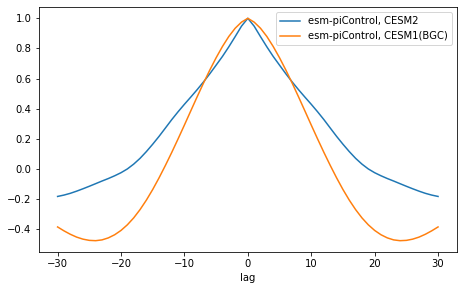

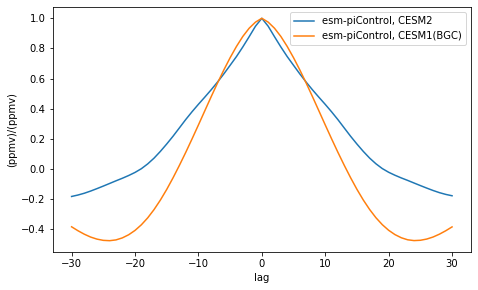

In [5]:
corr_anal(('CO2', 'CO2'), ['esm-piControl', 'esm-piControl-cmip5'])

varname_x=CO2, region_x=Global, varname_y=SFCO2_LND, region_y=Global


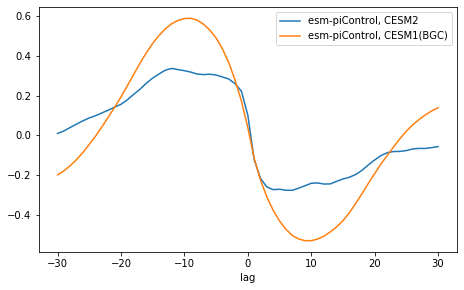

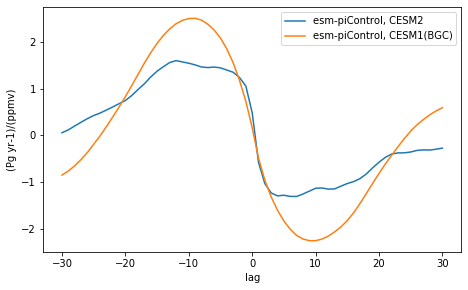

In [6]:
corr_anal(('CO2', 'SFCO2_LND'), ['esm-piControl', 'esm-piControl-cmip5'])

varname_x=CO2, region_x=Global, varname_y=SFCO2_OCN, region_y=Global


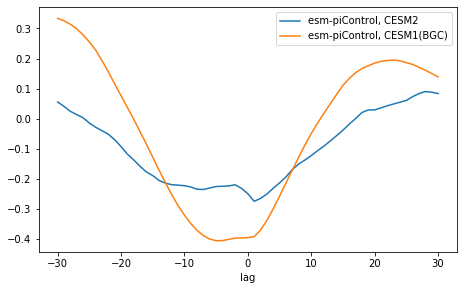

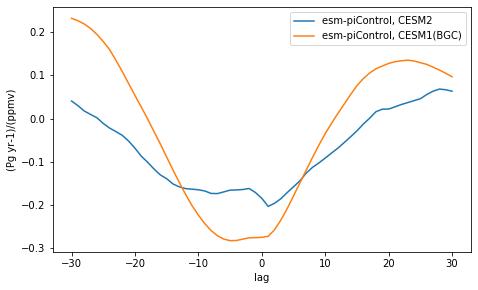

In [7]:
corr_anal(('CO2', 'SFCO2_OCN'), ['esm-piControl', 'esm-piControl-cmip5'])

varname_x=TS, region_x=nino34, varname_y=CO2, region_y=Global


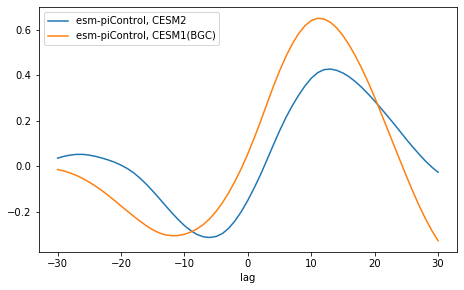

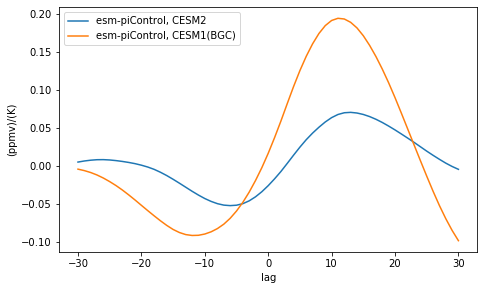

In [8]:
corr_anal(('TS', 'CO2'), ['esm-piControl', 'esm-piControl-cmip5'], region_x='nino34')

varname_x=SFCO2, region_x=Global, varname_y=CO2, region_y=Global
varname_x=SFCO2, region_x=Global, varname_y=CO2, region_y=Global


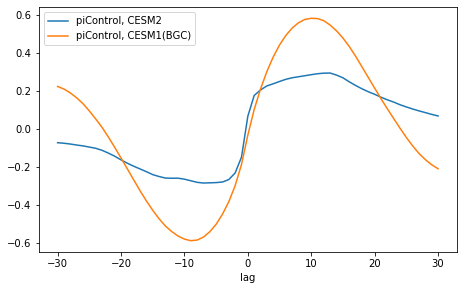

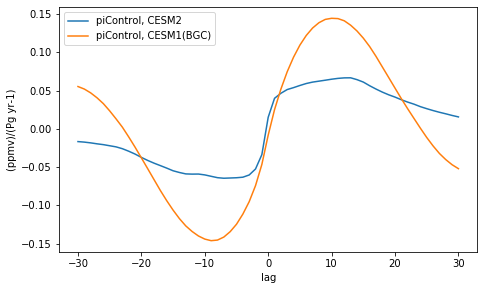

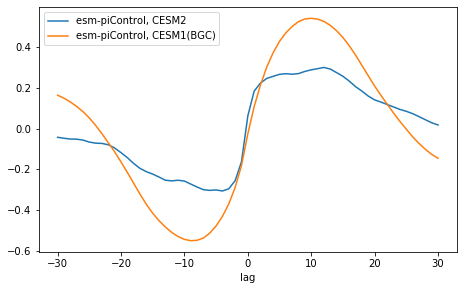

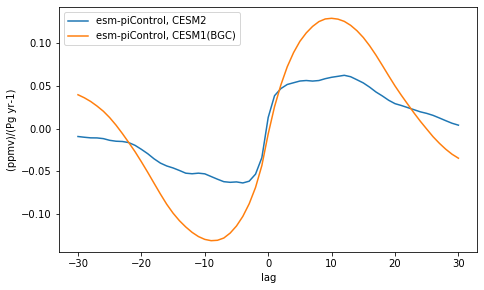

In [9]:
corr_anal(('SFCO2', 'CO2'), ['piControl', 'piControl-cmip5'], region_x='Global')
corr_anal(('SFCO2', 'CO2'), ['esm-piControl', 'esm-piControl-cmip5'], region_x='Global')

varname_x=TS, region_x=nino34, varname_y=TS, region_y=Global
varname_x=TS, region_x=nino34, varname_y=TS, region_y=nino34


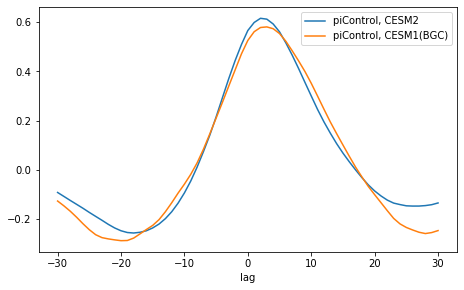

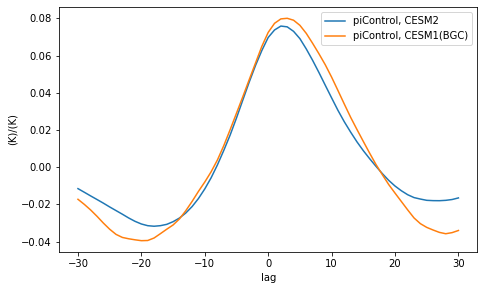

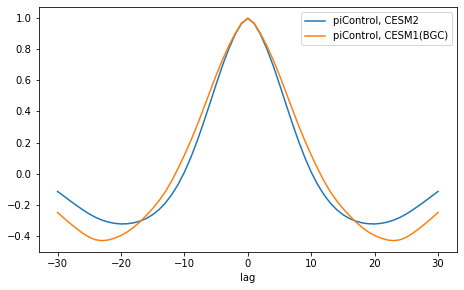

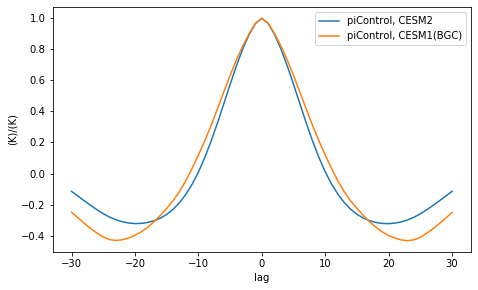

In [10]:
corr_anal(('TS', 'TS'), ['piControl', 'piControl-cmip5'], region_x='nino34', region_y_list=['Global', 'nino34'])